# 🥋 Lekcja 45: Higher (Różniczkowanie przez Optymalizator)

Standardowy problem w Meta-Learningu (MAML) lub optymalizacji hiperparametrów:
Chcemy znaleźć takie wagi początkowe $\theta$, które po wykonaniu jednego kroku $SGD$ dadzą mały błąd na nowym zadaniu.

$$ \min_{\theta} \mathcal{L}_{val}(\theta - \alpha \nabla \mathcal{L}_{train}(\theta)) $$

Musimy policzyć pochodną z funkcji, która w środku ma inną pochodną (krok optymalizatora).
PyTorchowy `optimizer.step()` "urywa" graf (robi operacje in-place).

Biblioteka **`higher`** pozwala na:
1.  **Monkey-patching:** Zamienia model w wersję bezstanową (functional).
2.  **Differentiable Optimizer:** Rejestruje historię aktualizacji wag, umożliwiając `backward` przez `step`.

Zaimplementujemy MAML w 10 linijkach, zamiast 50.

In [ ]:
# Instalacja biblioteki higher
# !uv add higher

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import higher

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K_SHOT = 5
META_LR = 1e-3

print(f"Urządzenie: {DEVICE}")

## Problem: Regresja Sinusoidy (MAML)

Zadanie jest to samo co w notatniku 75 poprzedniego kursu, ale kod będzie znacznie czystszy.
Model ma 5 punktów z nowej sinusoidy i musi się do niej dopasować w 1 kroku.

In [3]:
# Prosty model
class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# Generator zadań (Sinusoidy)
class SineWaveTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        
    def sample_data(self, k=5):
        x = np.random.uniform(-5, 5, size=(k, 1))
        y = self.amplitude * np.sin(x + self.phase)
        return torch.tensor(x, dtype=torch.float32).to(DEVICE), torch.tensor(y, dtype=torch.float32).to(DEVICE)

model = SineModel().to(DEVICE)
# To jest "Meta-Optymalizator" (uczy wagi początkowe)
meta_opt = optim.Adam(model.parameters(), lr=META_LR)

print("Model gotowy.")

Model gotowy.


## Magia `higher`

Zamiast pisać ręcznie `w = w - lr * grad`, użyjemy kontekstu `higher.innerloop_ctx`.

*   `fmodel`: To "funkcyjna" kopia naszego modelu. Możemy w nią "wstrzykiwać" wagi.
*   `diffopt`: To różniczkowalny optymalizator. Jego metoda `step` nie modyfikuje modelu w miejscu, ale zwraca nowe, wirtualne wagi.

Dzięki temu `loss` na końcu zależy od wag początkowych `model`, a ścieżka gradientu prowadzi przez `diffopt.step`.

Trening MAML z higher...
Step 0, Loss: 4.0873
Step 200, Loss: 3.0491
Step 400, Loss: 0.8098
Step 600, Loss: 2.9936
Step 800, Loss: 5.6578
Step 1000, Loss: 3.8712
Step 1200, Loss: 0.4202
Step 1400, Loss: 1.3607
Step 1600, Loss: 0.3670
Step 1800, Loss: 0.4916


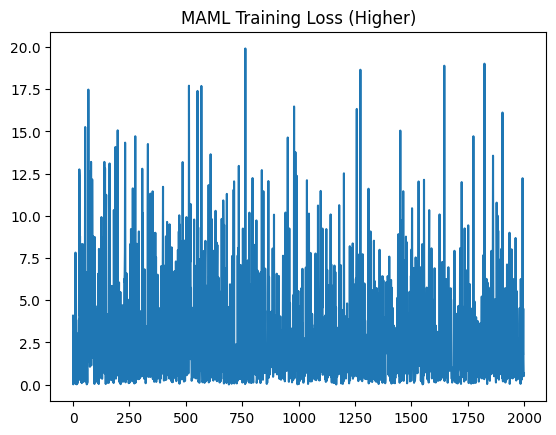

In [4]:
def train_maml_step(model, meta_opt):
    task = SineWaveTask()
    x_support, y_support = task.sample_data(K_SHOT) # Dane do nauki (Inner Loop)
    x_query, y_query = task.sample_data(K_SHOT)     # Dane do oceny (Outer Loop)
    
    # Definiujemy "wewnętrzny" optymalizator (zwykły SGD)
    # On będzie używany wewnątrz kontekstu higher
    inner_opt = optim.SGD(model.parameters(), lr=0.01)
    
    meta_opt.zero_grad()
    
    # --- HIGHER CONTEXT ---
    # copy_initial_weights=False: Chcemy, żeby gradienty płynęły do oryginalnego 'model'
    with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
        # 1. Inner Loop (Adaptacja)
        # Wykonujemy np. 1 lub 5 kroków adaptacji
        for _ in range(1):
            pred = fmodel(x_support)
            loss = F.mse_loss(pred, y_support)
            
            # MAGIA: diffopt.step wykonuje krok gradientu, ale zachowuje historię w grafie!
            diffopt.step(loss)
            
        # Po wyjściu z pętli 'fmodel' ma "zaktualizowane" wagi (fast weights).
        # Ale te wagi są połączone gradientem z wagami początkowymi!
        
        # 2. Outer Loop (Ewaluacja)
        # Sprawdzamy, jak zaadaptowany model radzi sobie na nowych danych
        pred_query = fmodel(x_query)
        meta_loss = F.mse_loss(pred_query, y_query)
        
        # 3. Meta-Update
        # Liczymy pochodną meta_loss względem ORYGINALNYCH parametrów 'model'
        # (przechodząc "przez" krok diffopt.step)
        meta_loss.backward()
        
    # Aktualizujemy "mózg matkę"
    meta_opt.step()
    return meta_loss.item()

import torch.nn.functional as F

print("Trening MAML z higher...")
losses = []
for i in range(2000):
    l = train_maml_step(model, meta_opt)
    losses.append(l)
    if i % 200 == 0: print(f"Step {i}, Loss: {l:.4f}")

plt.plot(losses)
plt.title("MAML Training Loss (Higher)")
plt.show()

## Weryfikacja Adaptacji

Sprawdźmy, czy model faktycznie potrafi nauczyć się nowej sinusoidy w **jednym kroku**.
Użyjemy `higher` również podczas testowania, bo to wygodne API do bezstanowego modelu.

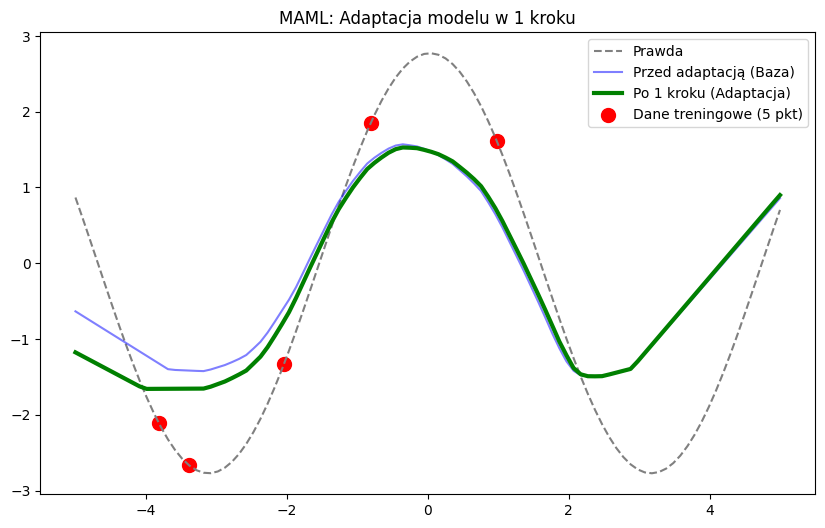

In [5]:
# Testujemy na nowym zadaniu
test_task = SineWaveTask()
x_supp, y_supp = test_task.sample_data(K_SHOT)
x_plot = torch.linspace(-5, 5, 100).view(-1, 1).to(DEVICE)

# 1. Przed adaptacją (Zero-shot)
with torch.no_grad():
    y_before = model(x_plot).cpu().numpy()

# 2. Adaptacja (One-shot)
inner_opt = optim.SGD(model.parameters(), lr=0.01)

# Używamy higher w trybie track_higher_grads=False (bo nie trenujemy już matki)
with higher.innerloop_ctx(model, inner_opt, track_higher_grads=False) as (fmodel, diffopt):
    # Krok adaptacji
    pred = fmodel(x_supp)
    loss = F.mse_loss(pred, y_supp)
    diffopt.step(loss)
    
    # Wynik po adaptacji
    y_after = fmodel(x_plot).cpu().detach().numpy()

# Wizualizacja
plt.figure(figsize=(10, 6))
y_true = test_task.amplitude * np.sin(x_plot.cpu().numpy() + test_task.phase)

plt.plot(x_plot.cpu(), y_true, label='Prawda', linestyle='--', color='gray')
plt.plot(x_plot.cpu(), y_before, label='Przed adaptacją (Baza)', color='blue', alpha=0.5)
plt.plot(x_plot.cpu(), y_after, label='Po 1 kroku (Adaptacja)', color='green', linewidth=3)
plt.scatter(x_supp.cpu(), y_supp.cpu(), color='red', s=100, label='Dane treningowe (5 pkt)')
plt.legend()
plt.title("MAML: Adaptacja modelu w 1 kroku")
plt.show()

## 🥋 Black Belt Summary

1.  **`higher`** to potężne narzędzie do **Differentiable Optimization**.
2.  Umożliwia liczenie gradientów **przez proces treningu**.
3.  **Zastosowania:**
    *   **Meta-Learning (MAML):** Uczenie inicjalizacji.
    *   **Hyperparameter Optimization:** Możesz traktować Learning Rate jako parametr trenowalny i różniczkować po nim!
    *   **Neural Architecture Search (NAS):** Różniczkowalny dobór architektury (DARTS).
    
To alternatywa dla ręcznego pisania `functional_call` w PyTorch, która obsługuje dowolnie skomplikowane optymalizatory (nawet Adama ze stanem momentum).